---
title       : "Introduction to Neural Networks" 
subtitle    : "Single Layer Perceptrons"
author      : Paul Schrimpf
date        : `j using Dates; print(Dates.today())`
bibliography: "../ml.bib"
options:
      out_width : 100%
      wrap : true
      fig_width : 800
      dpi : 192
---

[![](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-sa/4.0/)

This work is licensed under a [Creative Commons Attribution-ShareAlike
4.0 International
License](http://creativecommons.org/licenses/by-sa/4.0/) 


### About this document 

This document was created using Weave.jl. The code is available in
[on github](https://github.com/schrimpf/NeuralNetworkEconomics.jl). The same
document generates both static webpages and associated [jupyter
notebook](slp.ipynb). 

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

In [1]:
markdown = try
  "md" in keys(WEAVE_ARGS) && WEAVE_ARGS["md"]
catch
  false
end

if !("DISPLAY" ∈ keys(ENV))
  # Make gr and pyplot backends for Plots work without a DISPLAY
  ENV["GKSwstype"]="nul"
  ENV["MPLBACKEND"]="Agg"
end
# Make gr backend work with λ and other unicode
ENV["GKS_ENCODING"] = "utf-8"

using NeuralNetworkEconomics
docdir = joinpath(dirname(Base.pathof(NeuralNetworkEconomics)), "..","docs")

using Pkg
Pkg.activate(docdir)
Pkg.instantiate()

Activating environment at `~/.julia/dev/NeuralNetworkEconomics/docs/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


# Introduction

Neural networks, especially deep neural networks, have come to
dominate some areas of machine learning. Neural networks are
especially prominent in natural language processing, image
classification, and reinforcement learning. This documents gives a
brief introduction to neural networks. 

Examples in this document will use
[`Flux.jl`](https://fluxml.ai/Flux.jl/stable/). 
An alternative Julia package for deep learning is
[`Knet.jl`](https://denizyuret.github.io/Knet.jl/latest/). There is a
good discussion comparing Flux and Knet [on
discourse.](https://discourse.julialang.org/t/state-of-deep-learning-in-julia/28049). 
We will not have Knet examples here, but the documentation for Knet is
excellent and worth reading even if you plan to use Flux.

## Additional Reading

- @goodfellow2016 [*Deep Learning*](http://www.deeplearningbook.org)
- [`Knet.jl`
  documentation](https://denizyuret.github.io/Knet.jl/latest/)
  especially the textbook
- @klok2019 *Statistics with Julia:Fundamentals for Data Science,
  MachineLearning and Artificial Intelligence*
    
  
# Single Layer Neural Networks

We will describe neural networks from a perspective of nonparametric
estimation. Suppose we have a target function, $f: \R^p \to \R$. In
many applications the target function will be a conditional
expectation, $f(x) = \Er[y|x]$. 

A single layer neural network approximates $f$ as follows
$$
\hat{f}(x) = \sum_{j=1}^r \beta_j 
\psi(w_j'x + b_j)
$$
Here $r$ is the width of the layer. $\beta_j$ are scalars. 
$\psi:\R \to \R$ is a nonlinear activation function. Common activation
functions include:

- Sigmoid $\psi(t) = 1/(1+e^{-t})$

- Tanh $\psi(t) = \frac{e^t -e^{-t}}{e^t + e^{-t}}$

- Rectified linear $\psi(t) = t 1(t\geq 0)$

The $w_j \in \R^p$ are called weights and $b_j \in \R$ are biases. 

You may have heard about the universal approximation theorem. This
refers to the fact that as $r$ increases, a neural network can
approximate any function. Mathematically, for some large 
class of functions $\mathcal{F}$, 

$$
\sup_{f \in \mathcal{F}} \lim_{r \to \infty} \inf_{\beta, w, b} \Vert
f(x) - \sum_{j=1}^r \beta_j \psi(w_j'x+b_j) \Vert = 0
$$

@hornik1989 contains one of the earliest results along these
lines. Some introductory texts mention the universal approximation
theorem as though it is something special for neural networks. This is
incorrect. In particular, the universal approximation theorem does not
explain why neural networks seem to be unusually good at
prediction. Most nonparametric estimation methods (kernel, series,
forests, etc) satisfy a similar conditions. 

# Training 

Models in `Flux.jl` all involve a differentiable loss function. The
loss function is minimized by a variant of gradient descent. Gradients
are usually calculated using reverse automatic differentiation
(backpropagation is a variant of reverse automatic differentiation
specialized for the structue of neural networks). 

## Low level 

A low level way to use `Flux.jl` is to write your loss function as a
typical Julia function, as in the following code block.

In [2]:
using Plots, Flux, Statistics, ColorSchemes
# some function to estimate
f(x) = sin(x^x)/2^((x^x-π/2)/π)
function simulate(n,σ=1)
  x = rand(n,1).*π
  y = f.(x) .+ randn(n).*σ
  (x,y)
end

"""
   slp(r, activation=(t)-> 1 ./ (1 .+ exp.(.-t)), dimx=1 )

Construct a single layer perception with width `r`. 
"""
function slp(r, activation=(t)-> 1 ./ (1 .+ exp.(.-t)), dimx=1)
  # Parameters to be minimized wrt have to be declared for tracking
  # for reverse mode autodiff.
  w = param(randn(dimx,r))
  b = param(randn(1,r))
  β = param(randn(r))
  θ = Tracker.Params([β, w, b])
  pred(x) = activation(x*w.+b)*β
  loss(x,y) = mean((y.-pred(x)).^2)
  return(θ=θ, predict=pred,loss=loss)
end
x, y = simulate(1000, 0.5)
xg = 0:0.01:π
rs = [2, 3, 5, 7, 9]
cscheme = colorschemes[:Wistia];

1000 iteration, loss=0.3133150571482048
2000 iteration, loss=0.27526197882152165
3000 iteration, loss=0.25957614131929985
4000 iteration, loss=0.25089050194525864
5000 iteration, loss=0.24701559478931365
1000 iteration, loss=0.2943271012943402
2000 iteration, loss=0.2742854545845003
3000 iteration, loss=0.26333942298750734
4000 iteration, loss=0.25785994792164374
5000 iteration, loss=0.25458071985327924
1000 iteration, loss=0.2965057143241567
2000 iteration, loss=0.27331402004181515
3000 iteration, loss=0.2656344869303034
4000 iteration, loss=0.2612372208119076
5000 iteration, loss=0.25835680781077736
1000 iteration, loss=0.30427148885123473
2000 iteration, loss=0.2876053998093416
3000 iteration, loss=0.2743535471244317
4000 iteration, loss=0.26624556727602017
5000 iteration, loss=0.26012317727277606
1000 iteration, loss=0.310724080342714
2000 iteration, loss=0.29431716855906137
3000 iteration, loss=0.27833017569440266
4000 iteration, loss=0.2680111057237488
5000 iteration, loss=0.2612

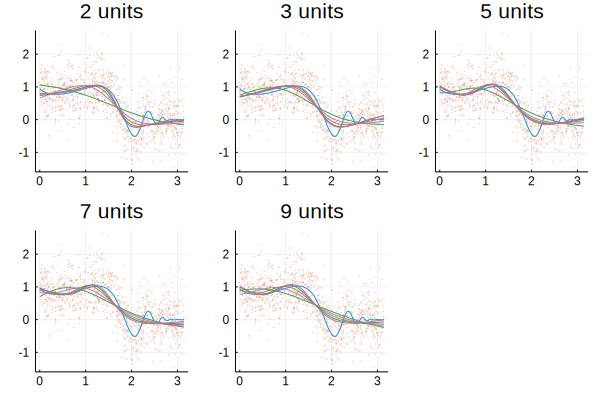

In [3]:
figs = Array{typeof(plot(0)),1}(undef,length(rs))
for r in eachindex(rs)
  m = slp(rs[r])
  figs[r]=plot(xg, f.(xg), lab="True f", title="$(rs[r]) units")
  figs[r]=scatter!(x,y, markeralpha=0.4, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 5000
  for i = 1:maxiter
    Flux.train!(m.loss, m.θ, [(x, y)], Flux.AMSGrad())
    if (i % (maxiter ÷ 5))==0
      l=Tracker.data(m.loss(x,y))
      println("$i iteration, loss=$l")
      figs[r]=plot!(xg,Tracker.data(m.predict(xg)), lab="") #, lab="$i iterations, loss=$l")
    end
  end
end
plot(figs..., legend=false)

Notice how even though a wider network can approximate $f$ better,
wider networks also take more training iterations to minimize the
loss. This is typical of any minimization algorithm --- the number of
iterations increases with the problem size. 

Each invocation of `Flux.train!` completes one iteration of gradient
descent. As you might guess from this API, it is common to train
neural networks for a fixed number of iterations instead of until
convergence to a local minimum. The number of training iterations can
act as a regularization parameter. 

## Chain interface

`Flux.jl` also contains some higher level functions for creating loss
functions for neural networks. Here is the same network as in the
previous code block, but using the higher level API.

2 units, 1 iterations, loss=1.4363599
2 units, 600 iterations, loss=0.30933282
2 units, 1200 iterations, loss=0.28223333
2 units, 1800 iterations, loss=0.25073335
2 units, 2400 iterations, loss=0.2448033


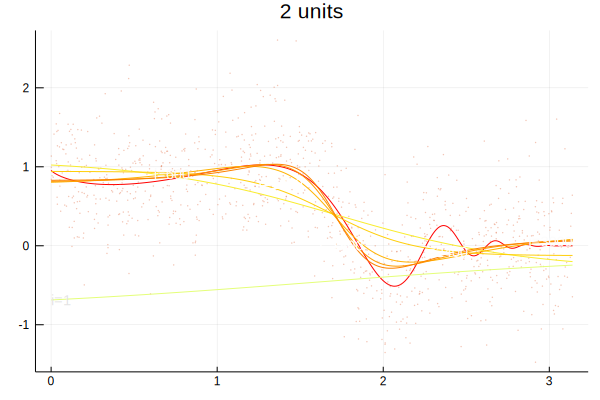

2 units, 3000 iterations, loss=0.24289756
3 units, 1 iterations, loss=2.5347862
3 units, 600 iterations, loss=0.29933402
3 units, 1200 iterations, loss=0.26250425
3 units, 1800 iterations, loss=0.24863638
3 units, 2400 iterations, loss=0.24395084


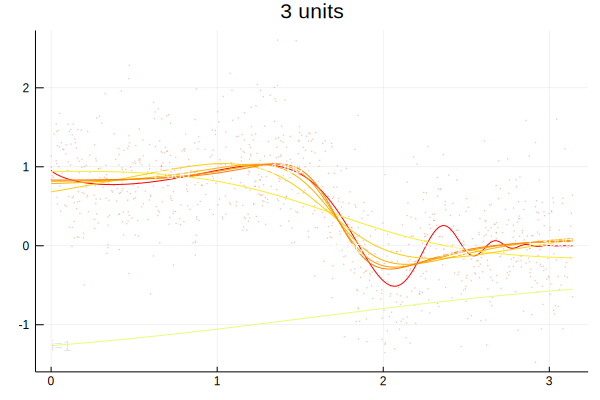

3 units, 3000 iterations, loss=0.24247554
5 units, 1 iterations, loss=2.4088979
5 units, 600 iterations, loss=0.2806205
5 units, 1200 iterations, loss=0.25854215
5 units, 1800 iterations, loss=0.24776423
5 units, 2400 iterations, loss=0.24381347


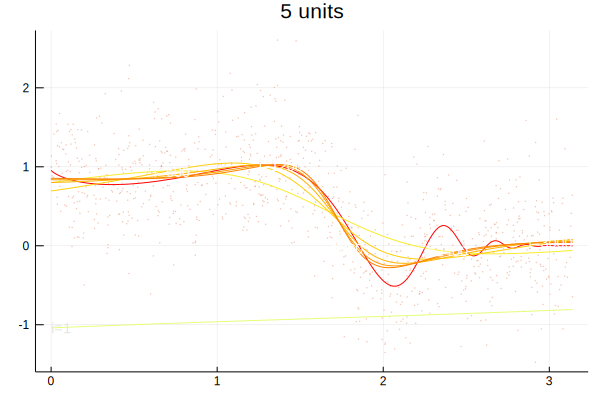

5 units, 3000 iterations, loss=0.24243166
7 units, 1 iterations, loss=0.7326573
7 units, 600 iterations, loss=0.287136
7 units, 1200 iterations, loss=0.2594584
7 units, 1800 iterations, loss=0.25083914
7 units, 2400 iterations, loss=0.24661215


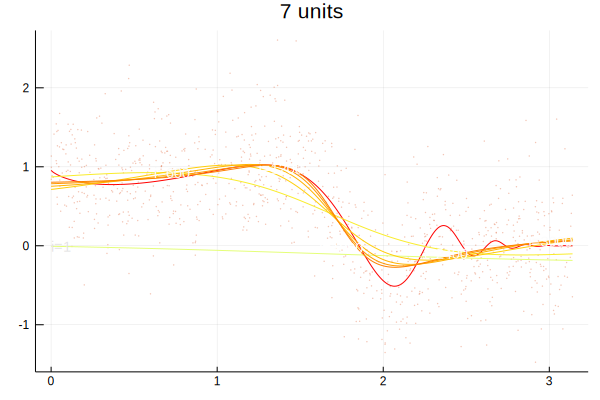

7 units, 3000 iterations, loss=0.24444155
9 units, 1 iterations, loss=0.6820606
9 units, 600 iterations, loss=0.29800045
9 units, 1200 iterations, loss=0.26437926
9 units, 1800 iterations, loss=0.25442532
9 units, 2400 iterations, loss=0.24958387


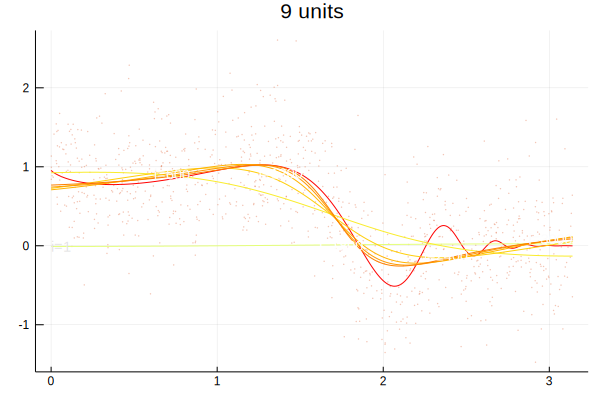

9 units, 3000 iterations, loss=0.24677506


In [4]:
dimx = 1
figs = Array{typeof(plot(0)),1}(undef,length(rs))
initmfigs = Array{typeof(plot(0)),1}(undef,length(rs))
xt = reshape(Float32.(x), 1, length(x))
yt = reshape(Float32.(y), 1, length(y))
for r in eachindex(rs)
  l = rs[r]
  m = Chain(x->Flux.normalise(x, dims=2), Dense(dimx, l, Flux.σ), Dense(rs[r], 1))
  initmfigs[r] = plot(xg, Tracker.data(m[1:(end-1)](xg'))', lab="", legend=false)
  figs[r]=plot(xg, f.(xg), lab="", title="$(rs[r]) units", color=:red)
  figs[r]=scatter!(x,y, alpha=0.4, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 3000
  for i = 1:maxiter
    Flux.train!((x,y)->Flux.mse(m(xt),yt), Flux.params(m), [(x, y)], Flux.AMSGrad() ) #,
                #cb = Flux.throttle(()->@show(Flux.mse(m(xt),yt)),100))
    if i==1 || (i % (maxiter ÷ 5))==0
      l=Tracker.data(Flux.mse(m(xt), yt))
      println("$(rs[r]) units, $i iterations, loss=$l")
      yg = Tracker.data(m(xg'))'
      loc=Int64.(ceil(length(xg)*i/maxiter))
      figs[r]=plot!(xg,yg, lab="", color=get(cscheme, i/maxiter), alpha=1.0,
                    annotations=(xg[loc], yg[loc],
                                 Plots.text("i=$i", i<maxiter/2 ? :left : :right, pointsize=10,
                                            color=get(cscheme, i/maxiter)) )
                    )
    end
  end
  display(figs[r])
end
#plot(figs...)

The figures do not appear identical to the first example since the
initial values differ, and the above code first normalises the
$x$s. 

## Initial values
 
Initial values are especially important with neural networks because
activation functions tend to be flat at the extremes. This causes the
gradient of the loss function to vanish in some regions of the
parameter space. For gradient descent to be successful, it is
important to avoid regions with vanishing gradients. The default
initial values of $w$ and $b$ used by Flux tend to work better with
normalised $x$. The initial activation are shown below.

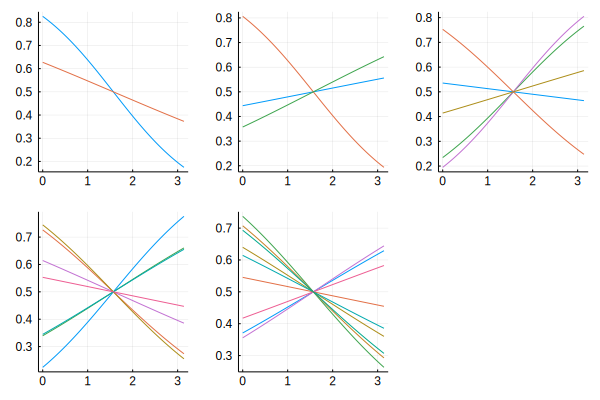

In [5]:
plot(initmfigs..., legend=false)

At these initial values, $w'x + b$, does change sign for each
activation, but $w'x$ is small enough that $\psi(w'x + b)$ is
approximately linear. This will make it initially difficult to
distinguish $\beta \psi'$ from $w$, 

We can improve the fit by choosing initial values even more
carefully.  The following code choses initial $w$ and $b$ to make sure
the activation functions vary nonlinearly in the support of $x$. 
The initial activations functions are plotted below.

In [6]:
dimx = 1
figs = Array{typeof(plot(0)),1}(undef,length(rs))
initmfigs = Array{typeof(plot(0)),1}(undef,length(rs))
xt = reshape(x, 1, length(x))
yt = reshape(y, 1, length(y))
for r in eachindex(rs)
  l = rs[r]
  m = Chain(Dense(dimx, l, Flux.σ), Dense(rs[r], 1))
  # adjust initial weights to make sure each node is nonlinear in support of X
  Tracker.update!(m[1].W, -m[1].W .+ sign.(Tracker.data(m[1].W))*2*π)
  # adjust initial intercepts to be in the support of w*x  
  Tracker.update!(m[1].b, -m[1].b .- m[1].W[:].*Float32.(π/(l+1):π/(l+1):π*l/(l+1)))
  # make initial output weights optimal given first layer
  X = vcat(1, Tracker.data(m[1](xt)))
  bols = (X*X') \ (X*Float32.(y))
  Tracker.update!(m[2].W, -m[2].W .+ bols[2:end]')
  Tracker.update!(m[2].b, -m[2].b .- Float32(Tracker.data(mean(m(xt) .- yt))))
  initmfigs[r] = plot(xg, Tracker.data(m[1](xg'))', lab="", legend=false)
  figs[r]=plot(xg, f.(xg), lab="", title="$(rs[r]) units", color=:red)
  figs[r]=scatter!(x,y, alpha=0.4, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 3000
  for i = 1:maxiter
    Flux.train!((x,y)->Flux.mse(m(xt),yt), Flux.params(m), [(x, y)], Flux.AMSGrad() ) #,
                #cb = Flux.throttle(()->@show(Flux.mse(m(xt),yt)),100))
    if i==1 || (i % (maxiter ÷ 5))==0
      l=Tracker.data(Flux.mse(m(xt), yt))
      println("$(rs[r]) units, $i iterations, loss=$l")
      yg = Tracker.data(m(xg'))'
      loc=Int64.(ceil(length(xg)*i/maxiter))
      figs[r]=plot!(xg,yg, lab="", color=get(cscheme, i/maxiter), alpha=1.0,
                    annotations=(xg[loc], yg[loc],
                                 Plots.text("i=$i", i<maxiter/2 ? :left : :right, pointsize=10,
                                            color=get(cscheme, i/maxiter)) )
                    )
    end
  end
end
nothing

2 units, 1 iterations, loss=0.3183805393937432
2 units, 600 iterations, loss=0.25475889446762195
2 units, 1200 iterations, loss=0.2534781944140394
2 units, 1800 iterations, loss=0.2509775378154624
2 units, 2400 iterations, loss=0.2431790636006112
2 units, 3000 iterations, loss=0.24237872261630747
3 units, 1 iterations, loss=0.2594581228230369
3 units, 600 iterations, loss=0.2444444076087773
3 units, 1200 iterations, loss=0.24254525049179088
3 units, 1800 iterations, loss=0.24174291649791682
3 units, 2400 iterations, loss=0.24127438797833367
3 units, 3000 iterations, loss=0.24095933566836167
5 units, 1 iterations, loss=0.2519861261284313
5 units, 600 iterations, loss=0.2434572844027898
5 units, 1200 iterations, loss=0.24203509507001134
5 units, 1800 iterations, loss=0.24155018162720873
5 units, 2400 iterations, loss=0.24123946203633026
5 units, 3000 iterations, loss=0.24101012066665728
7 units, 1 iterations, loss=0.2467257848239365
7 units, 600 iterations, loss=0.24082610061189846
7 uni

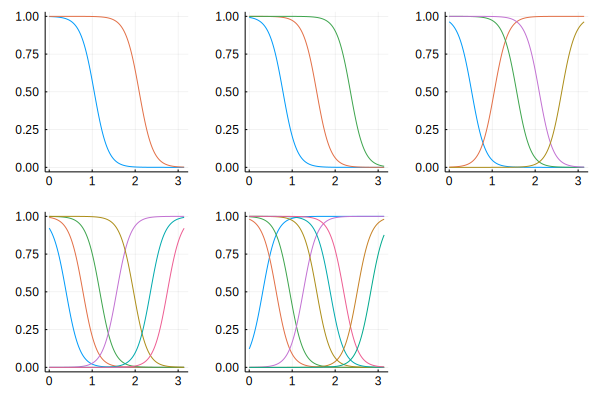

In [7]:
plot(initmfigs..., legend=false)

And the fit figures.

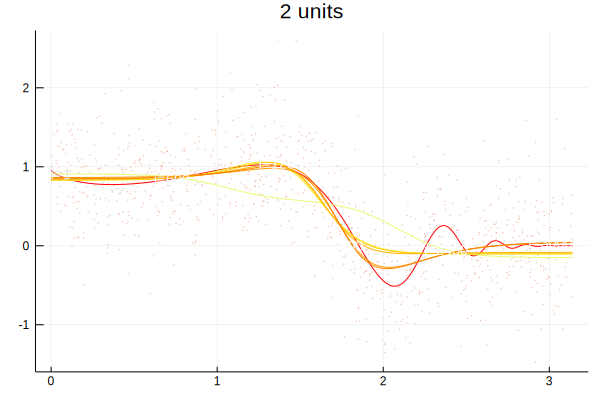

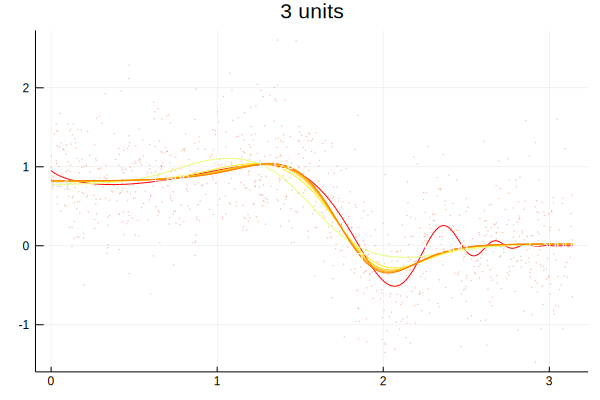

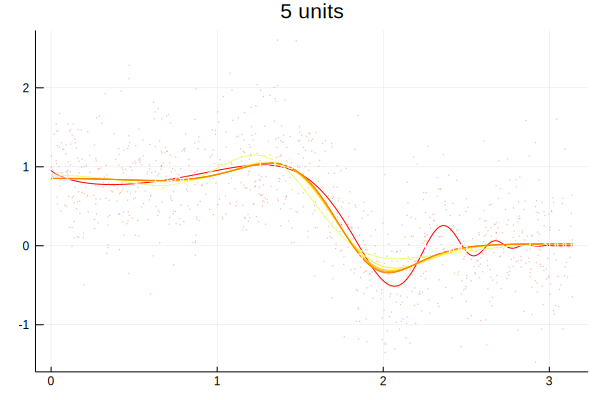

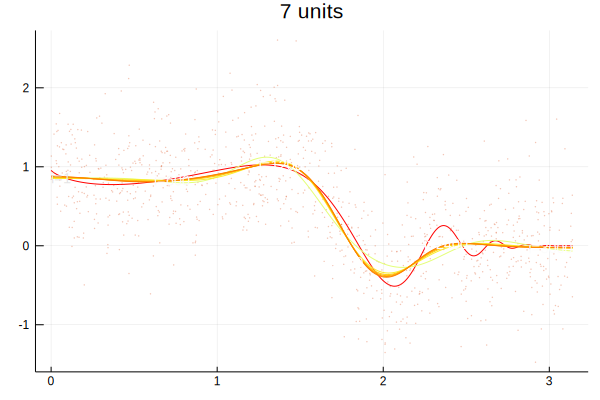

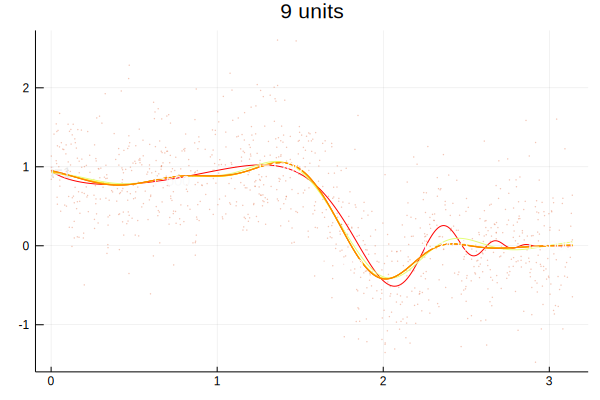

In [8]:
for f in figs
  display(f)
end

## Rectified linear

Large applications of neural networks often use rectified linear
activation for efficiency. Let's see how the same example behaves with
(leaky) rectified linear activation.

2 units, 1 iterations, loss=0.27320970144701545
2 units, 600 iterations, loss=0.26456865570889165
2 units, 1200 iterations, loss=0.26375041517424813
2 units, 1800 iterations, loss=0.2630414680728875
2 units, 2400 iterations, loss=0.26239660764133615
2 units, 3000 iterations, loss=0.2618028394149346
3 units, 1 iterations, loss=0.28632007881463356
3 units, 600 iterations, loss=0.2636698687502417
3 units, 1200 iterations, loss=0.2601889123476646
3 units, 1800 iterations, loss=0.25887862316603494
3 units, 2400 iterations, loss=0.2580170731404525
3 units, 3000 iterations, loss=0.257472146733473
5 units, 1 iterations, loss=0.25233956076245784
5 units, 600 iterations, loss=0.2493605138392948
5 units, 1200 iterations, loss=0.2480447700288671
5 units, 1800 iterations, loss=0.24705810159534583
5 units, 2400 iterations, loss=0.24623236656181458
5 units, 3000 iterations, loss=0.24539083594753502
7 units, 1 iterations, loss=0.24037512600136784
7 units, 600 iterations, loss=0.24217945788772471
7 uni

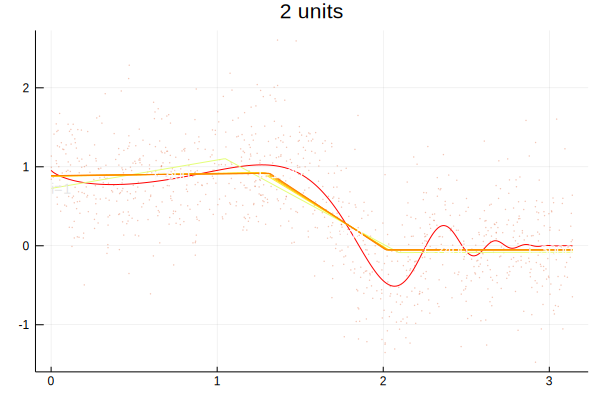

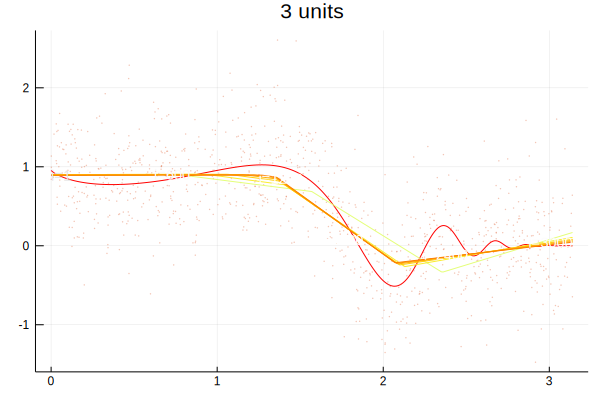

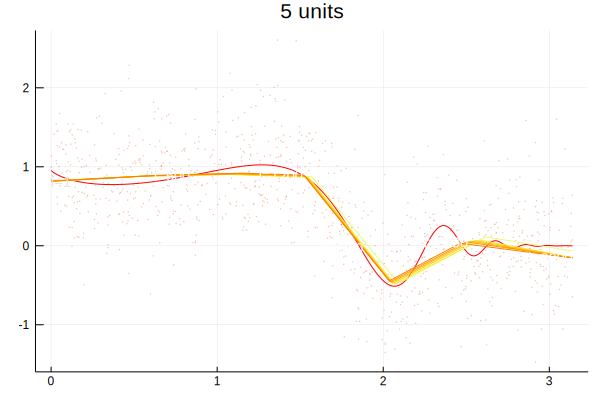

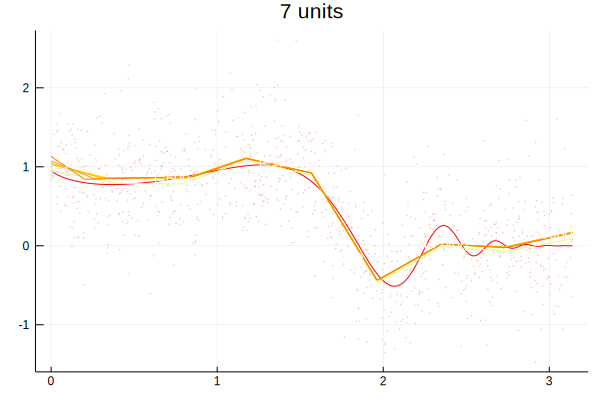

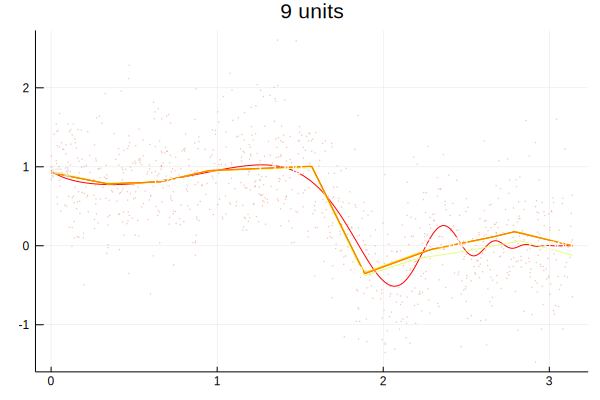

9 units, 3000 iterations, loss=0.24408792319691688


In [9]:
dimx = 1
figs = Array{typeof(plot(0)),1}(undef,length(rs))
for r in eachindex(rs)
  l = rs[r]
  m = Chain(Dense(dimx, rs[r], Flux.leakyrelu), Dense(rs[r], 1)) # notice the change
  # adjust initial weights to make sure each node is nonlinear in support of X
  Tracker.update!(m[1].W, -m[1].W .+ sign.(Tracker.data(m[1].W))*2*π)
  # # adjust initial intercepts to be in the support of w*x  
  Tracker.update!(m[1].b, -m[1].b .- m[1].W[:].*Float32.(π/(l+1):π/(l+1):π*l/(l+1)))
  # # make initial output weights optimal given first layer
  X = vcat(1, Tracker.data(m[1](xt)))
  bols = (X*X') \ (X*Float32.(y))
  Tracker.update!(m[2].W, -m[2].W .+ bols[2:end]')
  Tracker.update!(m[2].b, -m[2].b .- Float32(Tracker.data(mean(m(xt) .- yt))))
  initmfigs[r] = plot(xg, Tracker.data(m[1:(end-1)](xg'))', lab="", legend=false)
  figs[r]=plot(xg, f.(xg), lab="", title="$(rs[r]) units", color=:red)
  figs[r]=scatter!(x,y, alpha=0.4, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 3000
  for i = 1:maxiter
    Flux.train!((x,y)->Flux.mse(m(xt),yt), Flux.params(m), [(x, y)], Flux.AMSGrad() ) #,
                #cb = Flux.throttle(()->@show(Flux.mse(m(xt),yt)),100))
    if i==1 || (i % (maxiter ÷ 5))==0
      l=Tracker.data(Flux.mse(m(xt), yt))
      println("$(rs[r]) units, $i iterations, loss=$l")
      yg = Tracker.data(m(xg'))'
      loc=Int64.(ceil(length(xg)*i/maxiter))
      figs[r]=plot!(xg,yg, lab="", color=get(cscheme, i/maxiter), alpha=1.0,
                    annotations=(xg[loc], yg[loc],
                                 Plots.text("i=$i", i<maxiter/2 ? :left : :right, pointsize=10,
                                            color=get(cscheme, i/maxiter)) )
                    )
    end
  end
end
plot(initmfigs..., legend=false) 

for f in figs
  display(f)
end

# Rate of convergence

- @chen1999
- $f(x) = \Er[y|x]$ with Fourier representation
$$ f(x) = \int e^{i a'x} d\sigma_f(a) $$
  where $\int (\sqrt{a'a} \vee 1) d|\sigma_f|(a) < \infty$
- Network sieve :
$$ \begin{align*}
\mathcal{G}_n = \{ &
g: g(x) = \sum_{j=1}^{r_n} \beta_j (a_j'a_j \vee 1)^{-1}
\psi(a_j'x + b_j), \\ & \norm{\beta}_1 \leq B_n \}
\end{align*}
$$

The setup in @chen1999 is more general. They consider estimating both
$f$ and its first $m$ derivatives. Here, we focus on the case of just
estimating $f$. @chen1999 also consider estimation of functions other
than conditional expectations.

The restriction on $f$ in the second bullet is used to control
approximation error. The second bullet says that $f$ is the inverse
Fourier transform of measure $\sigma_f$. The bite of the restriction
on $f$ comes from the requirement that $\sigma_f$ be absolutely
integral, $\int (\sqrt{a'a} \vee 1) d|\sigma_f|(a) < \infty$. It would
be a good exercise to check whether this restriction is satisfied by
some familiar types of functions. @barron1993 first showed that neural
networks approximate this class of functions well, and compares the
approximation rate of neural networks to other function approximation
results.

# References